Importing essential libraries for data handling, visualization, and model building

In [2]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
%pip install tensorflow

  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
   ---------------------------------------- 0.0/375.9 MB ? eta -:--:--
   ---------------------------------------- 1.8/375.9 MB 12.6 MB/s eta 0:00:30
   ---------------------------------------- 3.4/375.9 MB 9.6 MB/s eta 0:00:39
   ---------------------------------------- 3.7/375.9 MB 7.5 MB/s eta 0:00:50
   ---------------------------------------- 4.5/375.9 MB 5.7 MB/s eta 0:01:06
    --------------------------------------- 5.0/375.9 MB 5.1 MB/s eta 0:01:13
    --------------------------------------- 5.5/375.9 MB 4.5 MB/s eta 0:01:23
    --------------------------------------- 5.8/375.9 MB 4.2 MB/s eta 0:01:28
    --------------------------------------- 6.3/375.9 MB 4.0 MB/s eta 0:01:32
    --------------------------------------- 7.1/375.9 MB 3.8 MB/s eta 0:01:38
    --------------------------------------- 7.6/375.9 MB 3.6 MB/s eta 0:01:42
    --------------------------------------- 8.1/375.9 MB 3.5 MB/s eta 0:01:45
    ---


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import os
import pandas as pd 
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Setting batch size and image dimensions

In [7]:
batch_size = 50
img_height = 300
img_width = 300

Loading and Preprocessing the Training Dataset

In [10]:
#loading the dataset with an 80-20 split for training and validation.

training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset',
    validation_split=0.2,
    subset="training",
    seed=42,  # Seed is used for reproducibility
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 4493 files belonging to 3 classes.
Using 3595 files for training.


In [11]:
# Extracting class names from the dataset for use in labeling and visualization

class_names = training_ds.class_names
class_names

['Bacterialblight', 'Brownspot', 'Leafsmut']

Previewing Random Images from the Training Dataset

In [12]:
# This section visualizes a few images to understand the dataset better.

plt.figure(figsize=(10, 10))  # Setting the figure size for the plot
for images, labels in training_ds.take(1):  # Taking one batch of images for display
    for i in range(12):  # Displaying the first 12 images in the batch
        ax = plt.subplot(3, 4, i + 1)  # Arranging images in a 3x4 grid
        plt.imshow(images[i].numpy().astype("uint8"))  # Displaying the image
        plt.title(class_names[labels[i]])  # Setting the title as the class name
        plt.axis('off')  # Hiding the axis for a cleaner look
        plt.grid(False)  # Disabling grid lines
plt.show()  # Showing the plot with images

Data Augmentation for Improving Model Generalization

In [13]:
# Data augmentation is applied to the training dataset to make the model more robust.

data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),  # Randomly flip images horizontally and vertically
    layers.RandomRotation(0.2),  # Randomly rotate images by up to 20%
    layers.RandomZoom(0.2),  # Randomly zoom into images by up to 20%
    layers.RandomContrast(0.2)  # Randomly adjust contrast by up to 20%
])

In [14]:
# Applying data augmentation to the training dataset

training_ds = training_ds.map(lambda x, y: (data_augmentation(x), y))

In [16]:
# Loading and Preprocessing the Validation Dataset
# The validation dataset is loaded similarly but without data augmentation.

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset',
    validation_split=0.2,
    subset="validation",
    seed=42,  # Ensuring reproducibility
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 4493 files belonging to 3 classes.
Using 898 files for validation.


Defining the Model Architecture

In [17]:
# A Sequential model is built with several convolutional layers, followed by dense layers.

model = models.Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),  # Input layer with the specified image shape
    layers.Rescaling(1./255),  # Rescaling pixel values to the range [0, 1]
    layers.Conv2D(32, 3, activation='relu'),  # First convolutional layer with 32 filters and ReLU activation
    layers.MaxPooling2D(),  # Max pooling layer to reduce spatial dimensions
    layers.Conv2D(64, 3, activation='relu'),  # Second convolutional layer with 64 filters
    layers.MaxPooling2D(),  # Max pooling layer
    layers.Conv2D(128, 3, activation='relu'),  # Third convolutional layer with 128 filters
    layers.MaxPooling2D(),  # Max pooling layer
    layers.Conv2D(256, 3, activation='relu'),  # Fourth convolutional layer with 256 filters
    layers.MaxPooling2D(),  # Max pooling layer
    layers.Flatten(),  # Flattening the output from convolutional layers to feed into dense layers
    layers.Dense(128, activation='relu'),  # Dense layer with 128 units and ReLU activation
    layers.Dropout(0.5),  # Dropout layer with 50% dropout rate to prevent overfitting
    layers.Dense(len(class_names), activation='softmax')  # Output layer with softmax activation for multi-class classification
])

Compiling the Model

In [18]:
# The model is compiled with the Adam optimizer, sparse categorical crossentropy loss, and accuracy metric.

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Adam optimizer with a learning rate of 0.001
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # Sparse categorical crossentropy loss
    metrics=['accuracy']  # Accuracy as the evaluation metric
)

Displaying the Model Summary

In [19]:
# The model summary provides an overview of the model architecture and parameters.

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 298, 298, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 147, 147, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 33, 33, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,777,539 (33.48 MB)

 Trainable params: 8,777,539 (33.48 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Defining Callbacks for Training
# Learning rate scheduler and early stopping are used to improve training efficiency and prevent overfitting.

lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Training the Model

In [21]:
# The model is trained for a specified number of epochs with the training and validation datasets.

epochs = 20
history = model.fit(
    training_ds,  # Training dataset
    validation_data=validation_ds,  # Validation dataset
    epochs=epochs,  # Number of training epochs
    callbacks=[lr_scheduler, early_stopping]  # Callbacks for learning rate scheduling and early stopping
)

Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 344s 5s/step - accuracy: 0.4518 - loss: 1.1560 - val_accuracy: 0.7494 - val_loss: 0.6572 - learning_rate: 0.0010
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 315s 4s/step - accuracy: 0.7116 - loss: 0.7264 - val_accuracy: 0.8274 - val_loss: 0.4949 - learning_rate: 0.0010
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 315s 4s/step - accuracy: 0.7359 - loss: 0.6592 - val_accuracy: 0.8140 - val_loss: 0.4930 - learning_rate: 0.0010
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 321s 4s/step - accuracy: 0.7831 - loss: 0.5390 - val_accuracy: 0.8519 - val_loss: 0.3893 - learning_rate: 0.0010
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 329s 4s/step - accuracy: 0.8206 - loss: 0.4543 - val_accuracy: 0.8664 - val_loss: 0.3454 - learning_rate: 0.0010
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 358s 5s/step - accuracy: 0.8444 - loss: 0.3895 - val_accuracy: 0.8318 - val_loss: 0.4285 - learning_rate: 0.0010
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 641s 9s/step - accuracy: 0.8375 - loss: 0.3913 - val_acc

Evaluation of the Model

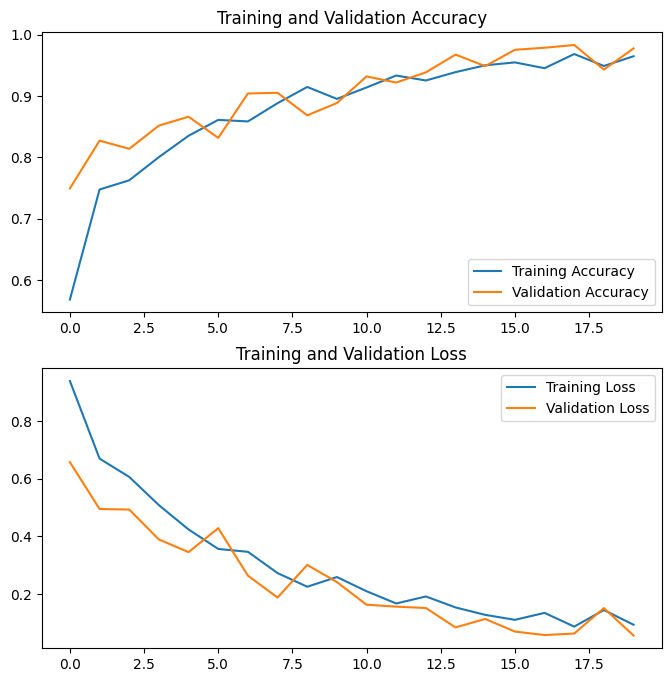

In [22]:
# The training and validation accuracy and loss are plotted to evaluate model performance.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))  # Setting the figure size for plots
plt.subplot(2, 1, 1)  # First subplot for accuracy
plt.plot(acc, label='Training Accuracy')  # Plotting training accuracy
plt.plot(val_acc, label='Validation Accuracy')  # Plotting validation accuracy
plt.legend(loc='lower right')  # Adding legend to the lower right
plt.title('Training and Validation Accuracy')  # Adding title

plt.subplot(2, 1, 2)  # Second subplot for loss
plt.plot(loss, label='Training Loss')  # Plotting training loss
plt.plot(val_loss, label='Validation Loss')  # Plotting validation loss
plt.legend(loc='upper right')  # Adding legend to the upper right
plt.title('Training and Validation Loss')  # Adding title
plt.show()  # Displaying the plots

In [23]:
# Displaying the Maximum Validation Accuracy
# The maximum validation accuracy is printed to assess the best model performance.

print("Maximum Validation Accuracy:", max(val_acc))

Maximum Validation Accuracy: 0.9832962155342102


Model Testing

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step


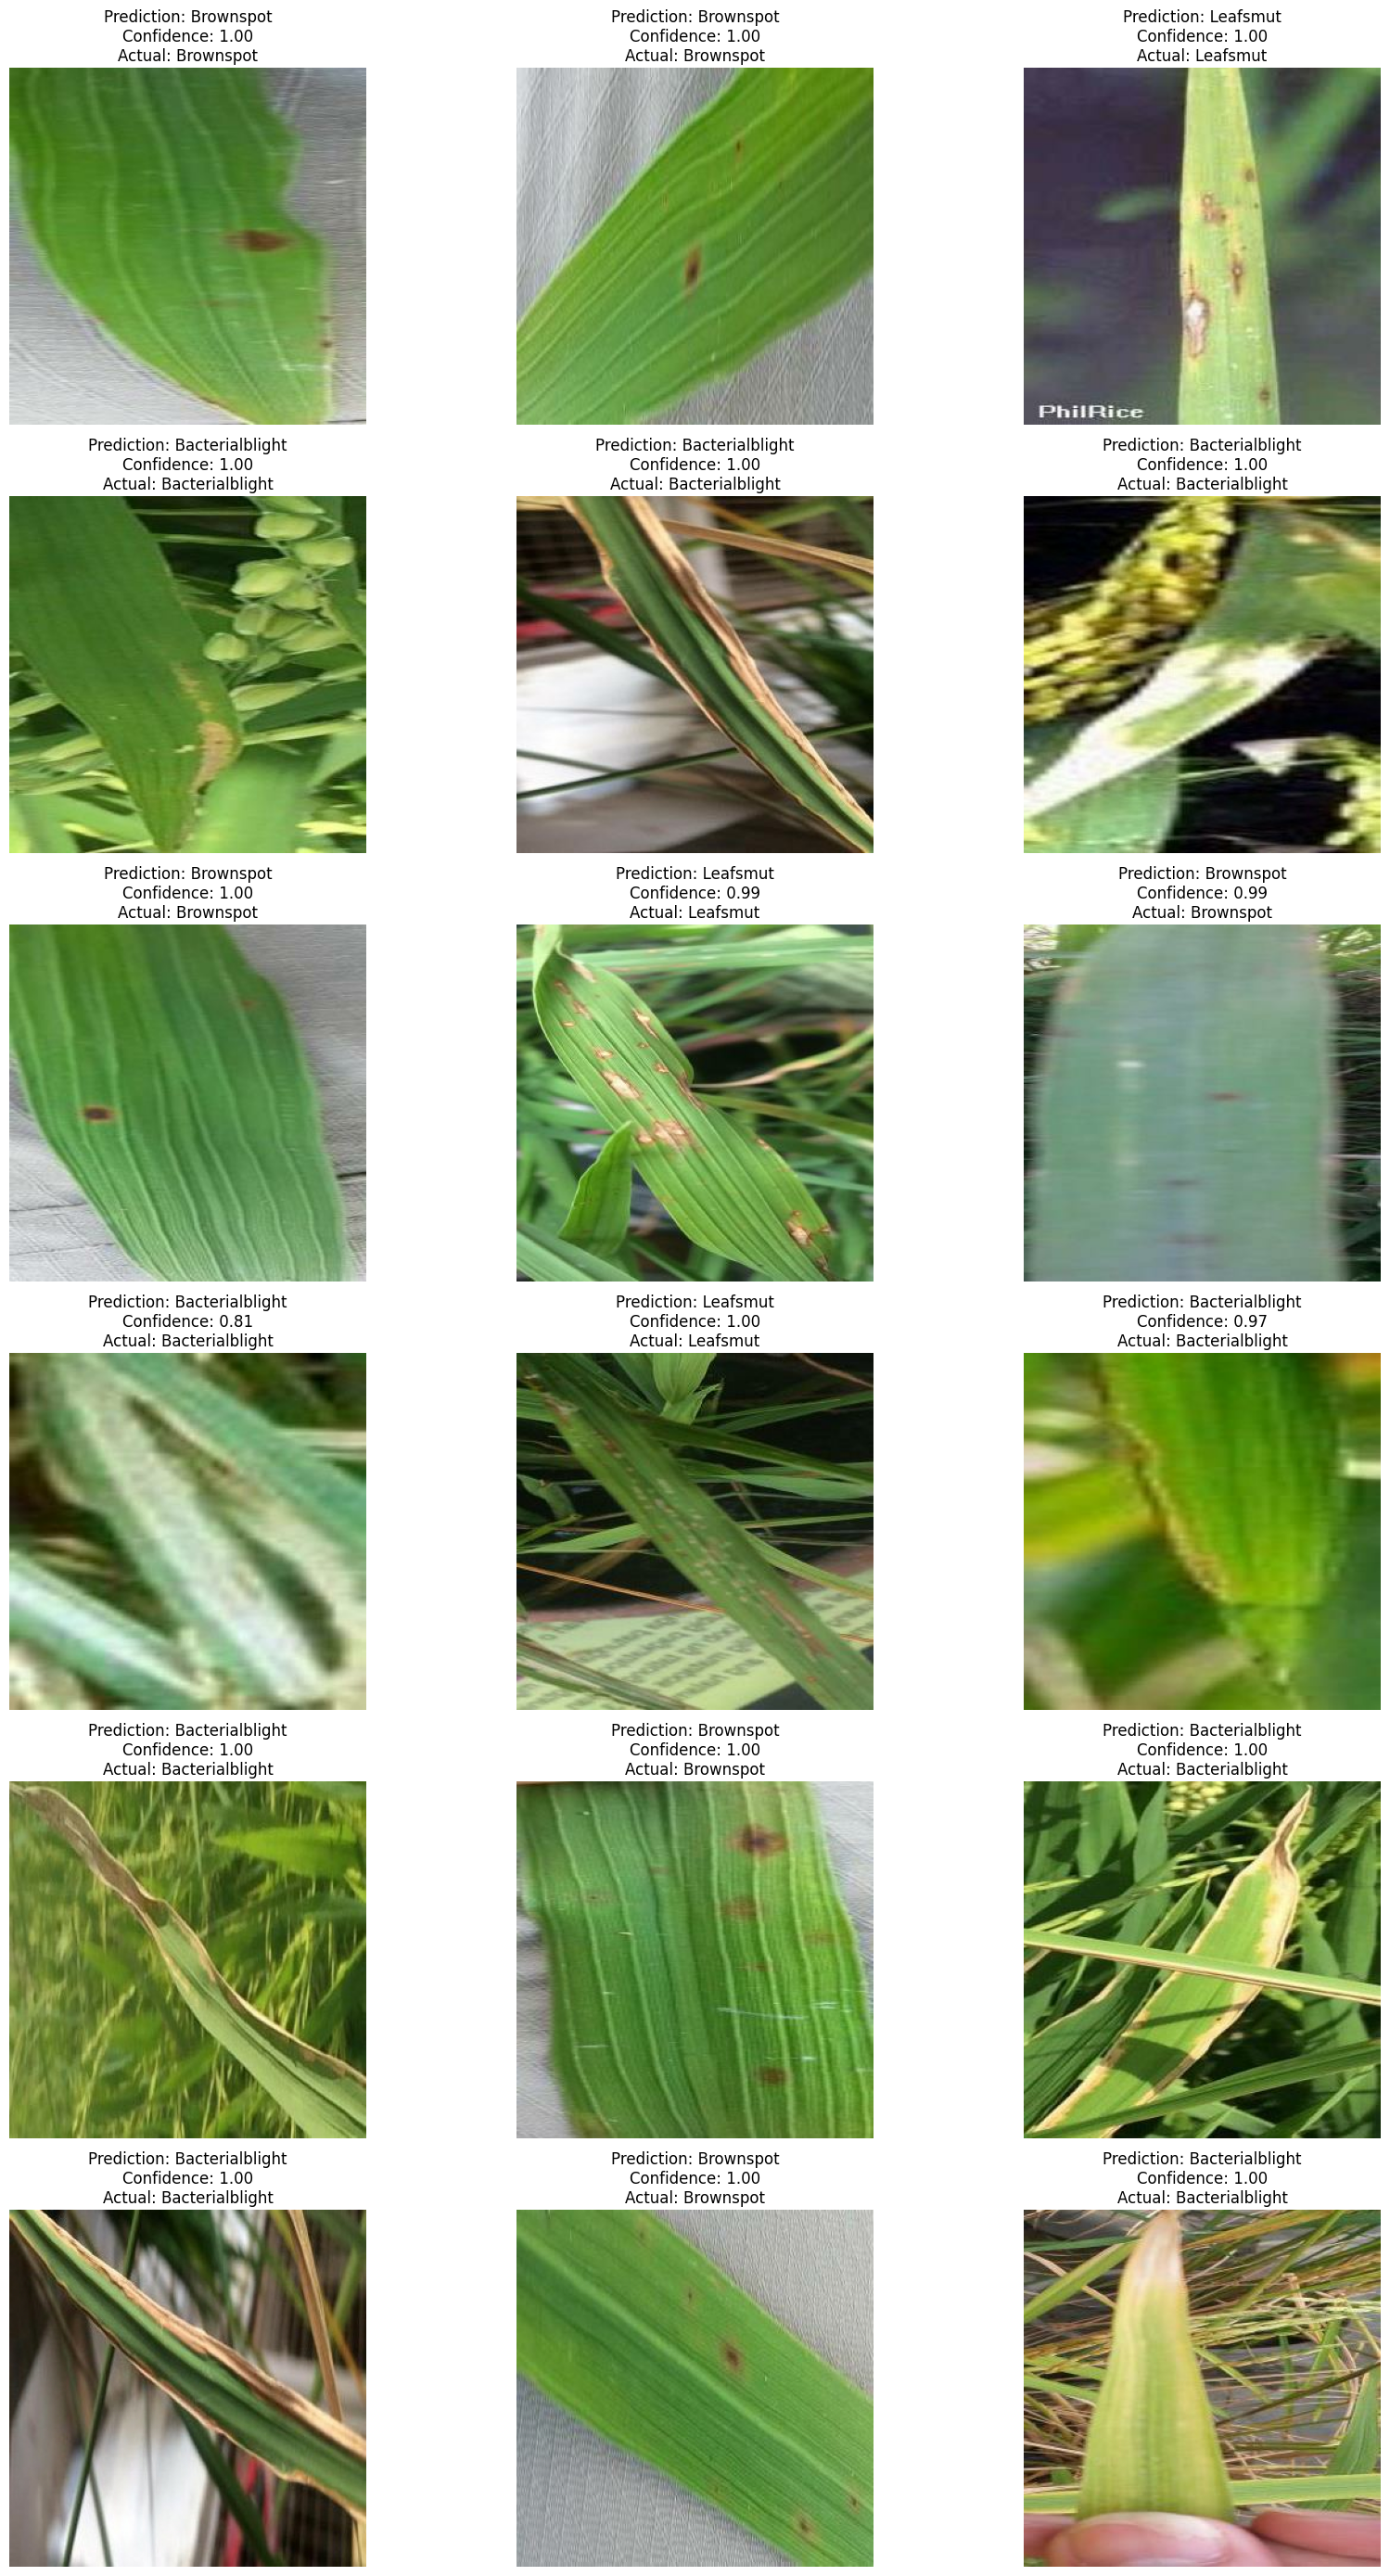

In [24]:
# On the Validation Dataset
# The model's predictions are visualized alongside the actual labels, including the prediction confidence.
plt.figure(figsize=(20, 35))  # Setting the figure size for evaluation plots

for images, labels in validation_ds.take(1):  # Taking one batch from the validation dataset
    predictions = model.predict(images)  # Making predictions on the batch
    pred_labels = [class_names[np.argmax(pred)] for pred in predictions]  # Converting predictions to class names
    pred_confidences = [np.max(pred) for pred in predictions]  # Extracting the maximum confidence for each prediction

    # Displaying the first 20 predictions
    for i in range(18):  # Displaying the first 20 images
        ax = plt.subplot(6, 3, i + 1)  # Arranging in a 6x3 grid
        plt.imshow(images[i].numpy().astype("uint8"))  # Displaying the image
        plt.title(f'Prediction: {pred_labels[i]}\nConfidence: {pred_confidences[i]:.2f}\nActual: {class_names[labels[i]]}')  # Displaying predicted label, confidence, and actual label
        plt.axis('off')  # Hiding axis for a cleaner look
        plt.grid(False)  # Disabling grid lines

plt.show()  # Showing the evaluation plot

In [25]:
model.save('model/paddy_model.h5')